
[1] LOADING REAL DATASETS...
Loading Mental Health Counseling Dataset...
Loading Counsel Chat Dataset...
Loading Counsel Chat Dataset...


Repo card metadata block was not found. Setting CardData to empty.


✓ AI Conversations loaded: 3512 records
✓ Human Therapy loaded: 2775 records

[2] PREPROCESSING TEXT DATA...

Processing AI conversations (using 'Context' column)...
  - Cleaning text from column: Context
  - Calculating emotional scores...
  - Calculating emotional scores...
  - Calculating sentiment...
  - Calculating sentiment...
  - Extracting linguistic features...
  - Extracting linguistic features...

Processing human therapy conversations (using 'questionText' column)...
  - Cleaning text from column: questionText

Processing human therapy conversations (using 'questionText' column)...
  - Cleaning text from column: questionText
  - Calculating emotional scores...
  - Calculating emotional scores...
  - Calculating sentiment...
  - Calculating sentiment...
  - Extracting linguistic features...

✓ Final AI dataset: 3378 conversations
✓ Final Human dataset: 2532 conversations

[3] STATISTICAL POWER ANALYSIS...
  - Extracting linguistic features...

✓ Final AI dataset: 3378 conver

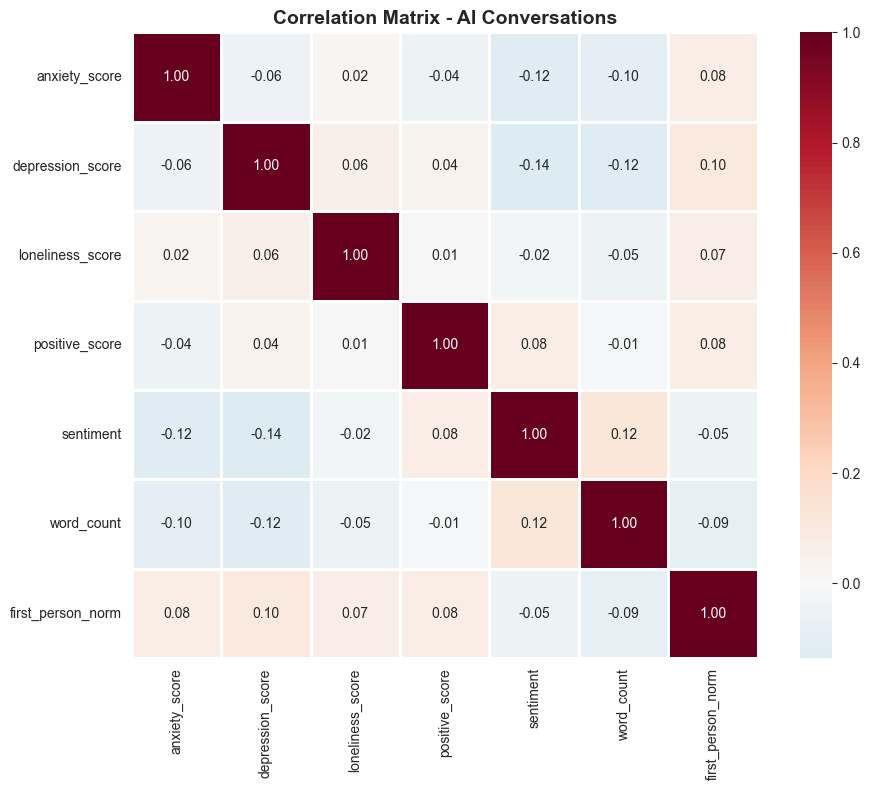


[7] MACHINE LEARNING CLASSIFICATION...

Cross-Validation Accuracy: 0.483 (+/- 0.012)

Cross-Validation Accuracy: 0.483 (+/- 0.012)

Feature Importance (Top 10):
          Feature  Importance
        sentiment    0.211801
       word_count    0.204519
first_person_norm    0.192296
   sentence_count    0.110499
    anxiety_score    0.073579
 depression_score    0.054761
   question_count    0.051889
      anger_score    0.037892
 loneliness_score    0.032853
   positive_score    0.029912

Feature Importance (Top 10):
          Feature  Importance
        sentiment    0.211801
       word_count    0.204519
first_person_norm    0.192296
   sentence_count    0.110499
    anxiety_score    0.073579
 depression_score    0.054761
   question_count    0.051889
      anger_score    0.037892
 loneliness_score    0.032853
   positive_score    0.029912
✓ Saved: feature_importance.png
✓ Saved: feature_importance.png


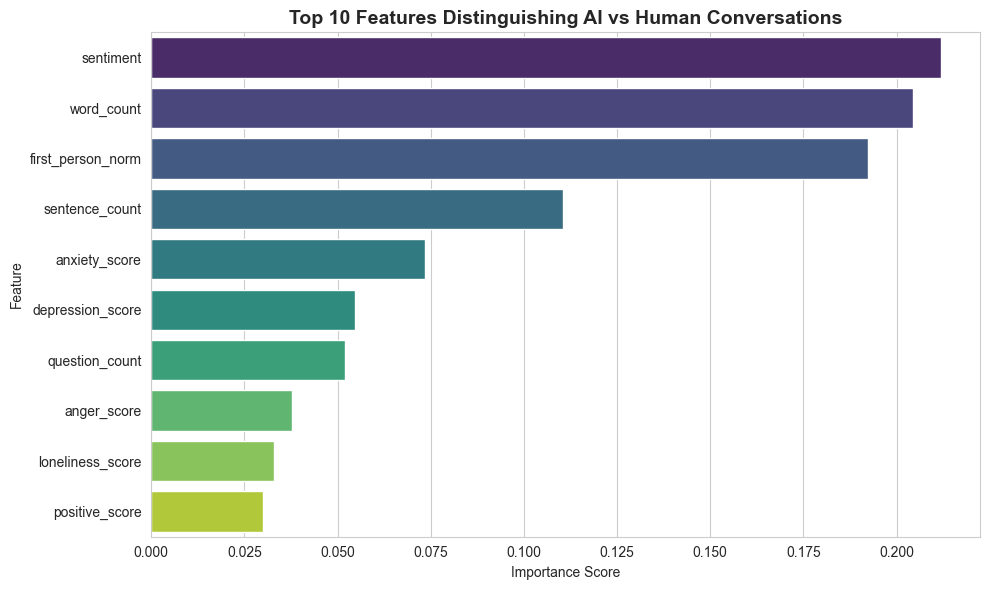


[8] GENERATING VISUALIZATIONS...
✓ Saved: emotional_comparison_boxplots.png
✓ Saved: emotional_comparison_boxplots.png


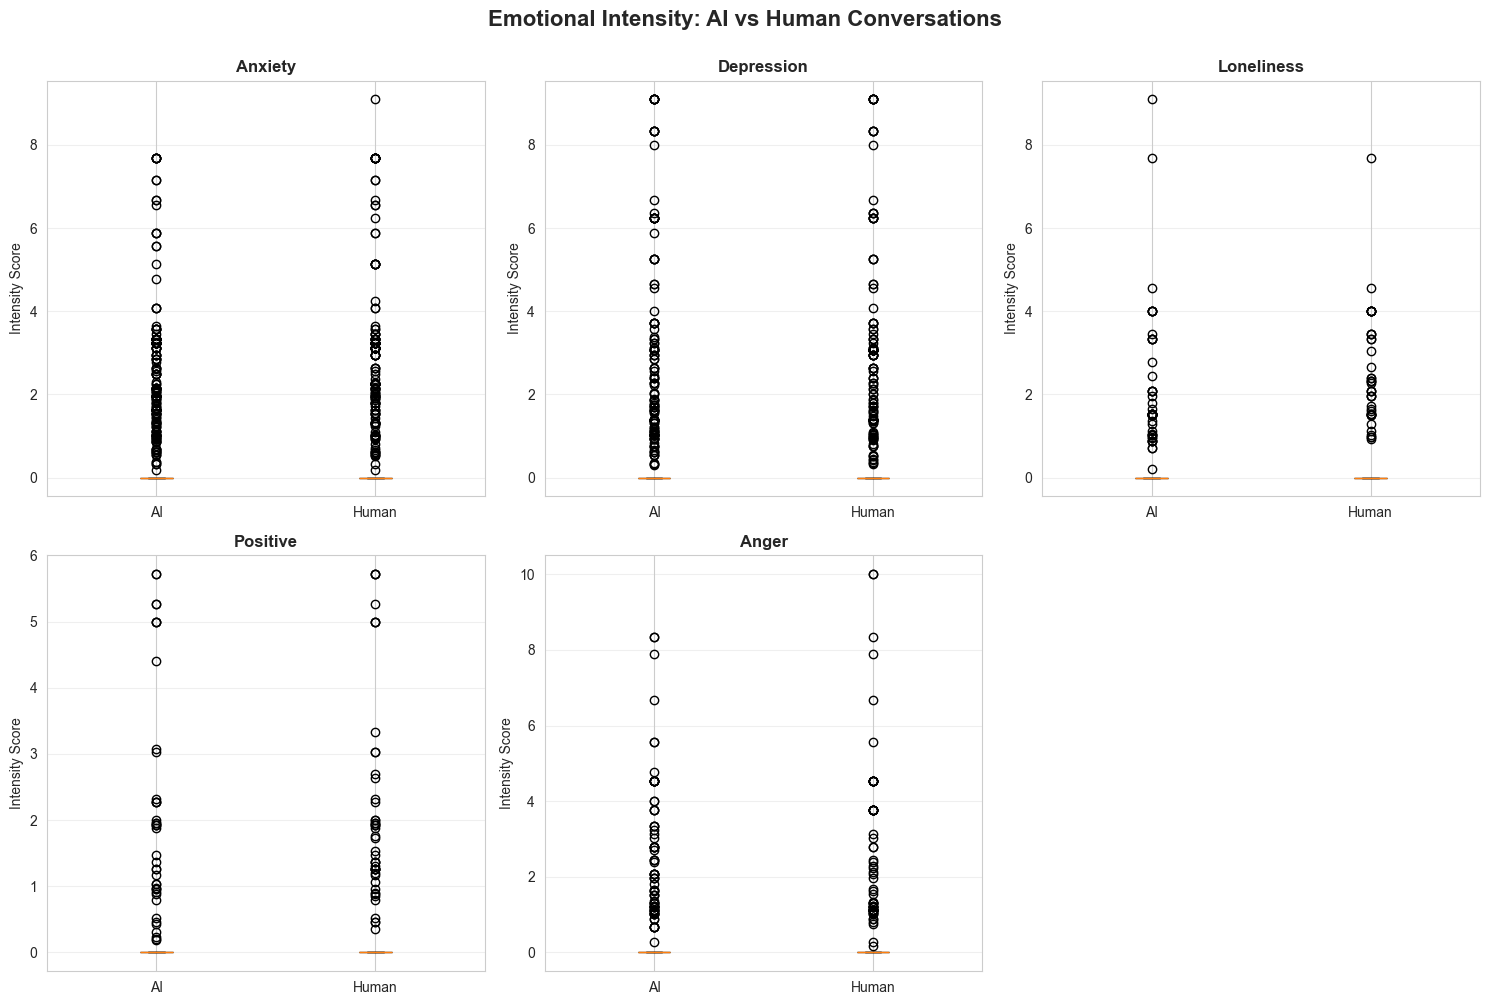

✓ Saved: sentiment_comparison.png


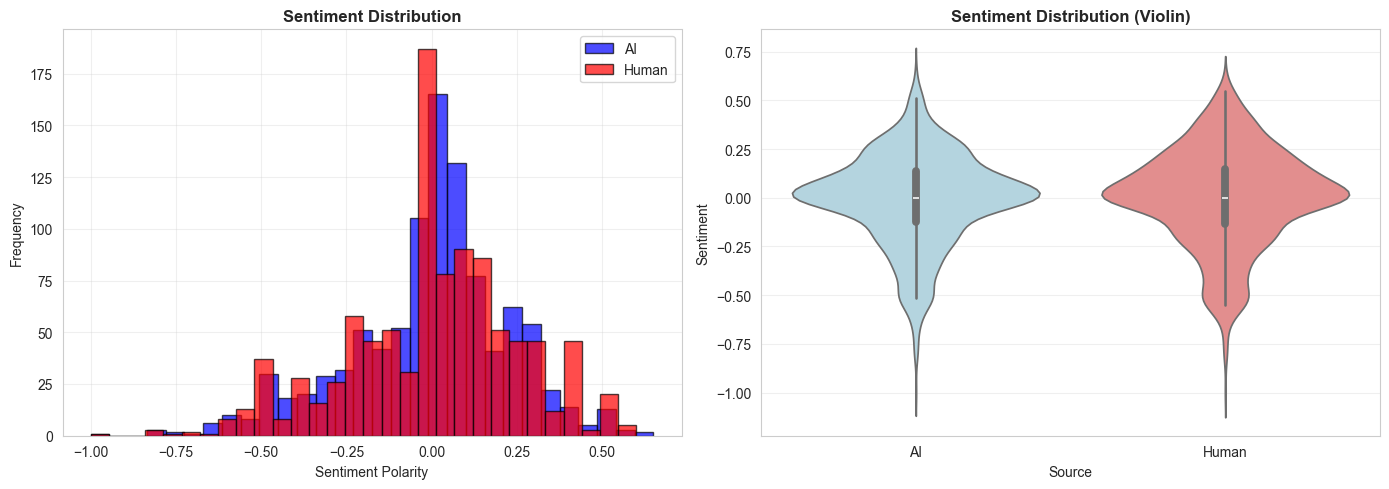

✓ Saved: self_disclosure_scatter.png


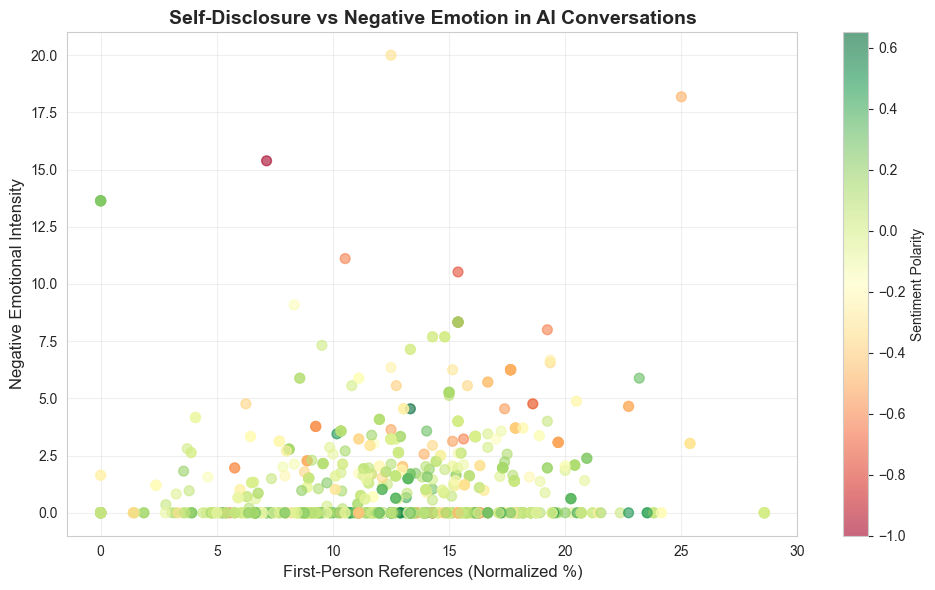


[9] EXPORTING RESULTS...
✓ Saved: processed_conversations.csv
✓ Saved: statistical_comparison.csv
✓ Saved: correlation_matrix.csv
✓ Saved: analysis_summary.txt


Generated Files:
  1. correlation_matrix_ai.png
  2. feature_importance.png
  3. emotional_comparison_boxplots.png
  4. sentiment_comparison.png
  5. self_disclosure_scatter.png
  6. processed_conversations.csv
  7. statistical_comparison.csv
  8. correlation_matrix.csv
  9. analysis_summary.txt
✓ Saved: processed_conversations.csv
✓ Saved: statistical_comparison.csv
✓ Saved: correlation_matrix.csv
✓ Saved: analysis_summary.txt


Generated Files:
  1. correlation_matrix_ai.png
  2. feature_importance.png
  3. emotional_comparison_boxplots.png
  4. sentiment_comparison.png
  5. self_disclosure_scatter.png
  6. processed_conversations.csv
  7. statistical_comparison.csv
  8. correlation_matrix.csv
  9. analysis_summary.txt


In [8]:
"""
Complete Statistical Analysis of AI Mental Health Conversations
Fixed version with correct column names - DISPLAYS ALL CHARTS
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Text processing libraries
import re
from textblob import TextBlob

# Try to import statsmodels
try:
    from statsmodels.stats.multitest import multipletests
    from statsmodels.stats.power import TTestIndPower
    HAS_STATSMODELS = True
except ImportError:
    HAS_STATSMODELS = False
    def multipletests(pvals, alpha=0.05, method='bonferroni'):
        pvals = np.array(pvals)
        n = len(pvals)
        p_corrected = pvals * n
        p_corrected = np.clip(p_corrected, 0, 1)
        reject = p_corrected < alpha
        return reject, p_corrected, alpha, alpha
    
    class TTestIndPower:
        def solve_power(self, effect_size, alpha, power, alternative='two-sided'):
            from scipy.stats import norm
            z_alpha = norm.ppf(1 - alpha/2)
            z_beta = norm.ppf(power)
            n = 2 * ((z_alpha + z_beta) / effect_size) ** 2
            return n

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 80)
print("MENTAL HEALTH CONVERSATION ANALYSIS - REAL DATA")
print("=" * 80)

# ============================================================================
# PART 1: DATA ACQUISITION
# ============================================================================

print("\n[1] LOADING REAL DATASETS...")

try:
    from datasets import load_dataset
    
    print("Loading Mental Health Counseling Dataset...")
    mental_health_ds = load_dataset("Amod/mental_health_counseling_conversations")
    ai_conversations = pd.DataFrame(mental_health_ds['train'])
    
    print("Loading Counsel Chat Dataset...")
    counsel_ds = load_dataset("nbertagnolli/counsel-chat")
    human_therapy = pd.DataFrame(counsel_ds['train'])
    
    print(f"✓ AI Conversations loaded: {len(ai_conversations)} records")
    print(f"✓ Human Therapy loaded: {len(human_therapy)} records")
    
except Exception as e:
    print(f"ERROR loading datasets: {e}")
    exit()

# ============================================================================
# PART 2: EMOTIONAL KEYWORD DICTIONARIES
# ============================================================================

EMOTIONAL_KEYWORDS = {
    'anxiety': ['anxious', 'worried', 'nervous', 'panic', 'stress', 'overwhelmed', 
                'afraid', 'scared', 'fear', 'terrified', 'tense', 'restless'],
    'depression': ['sad', 'hopeless', 'empty', 'worthless', 'depressed', 'down', 
                   'miserable', 'despair', 'helpless', 'defeated', 'discouraged'],
    'loneliness': ['lonely', 'alone', 'isolated', 'abandoned', 'disconnected', 
                   'friendless', 'solitary', 'excluded', 'rejected', 'outcast'],
    'positive': ['happy', 'grateful', 'hopeful', 'confident', 'peaceful', 'calm', 
                 'joyful', 'content', 'optimistic', 'blessed', 'thankful'],
    'anger': ['angry', 'mad', 'furious', 'irritated', 'frustrated', 'annoyed', 
              'rage', 'hostile', 'bitter', 'resentful']
}

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def calculate_emotional_scores(text, keywords_dict):
    if not text:
        return {emotion: 0.0 for emotion in keywords_dict.keys()}
    
    words = text.split()
    word_count = len(words)
    if word_count == 0:
        return {emotion: 0.0 for emotion in keywords_dict.keys()}
    
    scores = {}
    for emotion, keywords in keywords_dict.items():
        count = sum(1 for word in words if word in keywords)
        scores[emotion] = (count / word_count) * 100
    
    return scores

def get_sentiment(text):
    if not text:
        return 0.0
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return 0.0

def extract_features(df, text_column):
    print(f"  - Cleaning text from column: {text_column}")
    df['clean_text'] = df[text_column].apply(clean_text)
    
    print(f"  - Calculating emotional scores...")
    emotional_scores = df['clean_text'].apply(
        lambda x: calculate_emotional_scores(x, EMOTIONAL_KEYWORDS)
    )
    for emotion in EMOTIONAL_KEYWORDS.keys():
        df[f'{emotion}_score'] = emotional_scores.apply(lambda x: x[emotion])
    
    print(f"  - Calculating sentiment...")
    df['sentiment'] = df['clean_text'].apply(get_sentiment)
    
    print(f"  - Extracting linguistic features...")
    df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
    df['char_count'] = df['clean_text'].apply(len)
    df['sentence_count'] = df[text_column].apply(lambda x: len(str(x).split('.')))
    df['question_count'] = df[text_column].apply(lambda x: str(x).count('?'))
    df['first_person'] = df['clean_text'].apply(
        lambda x: sum(1 for w in x.split() if w in ['i', 'me', 'my', 'myself'])
    )
    df['first_person_norm'] = df['first_person'] / (df['word_count'] + 1) * 100
    
    df['total_emotion'] = df[[f'{e}_score' for e in EMOTIONAL_KEYWORDS.keys()]].sum(axis=1)
    df['negative_emotion'] = df[['anxiety_score', 'depression_score', 'loneliness_score', 'anger_score']].sum(axis=1)
    
    df = df[df['word_count'] >= 10].copy()
    
    return df

# ============================================================================
# PART 3: PROCESS DATA
# ============================================================================

print("\n[2] PREPROCESSING TEXT DATA...")

# Use correct column names: 'Context' for AI, 'questionText' for Human
print("\nProcessing AI conversations (using 'Context' column)...")
ai_df = extract_features(ai_conversations, 'Context')
ai_df['source'] = 'AI'

print("\nProcessing human therapy conversations (using 'questionText' column)...")
human_df = extract_features(human_therapy, 'questionText')
human_df['source'] = 'Human'

print(f"\n✓ Final AI dataset: {len(ai_df)} conversations")
print(f"✓ Final Human dataset: {len(human_df)} conversations")

# ============================================================================
# PART 4: POWER ANALYSIS
# ============================================================================

print("\n[3] STATISTICAL POWER ANALYSIS...")

power_analysis = TTestIndPower()
required_sample = power_analysis.solve_power(
    effect_size=0.5,
    alpha=0.05,
    power=0.80,
    alternative='two-sided'
)

print(f"\nRequired sample size per group (80% power, d=0.5): {required_sample:.0f}")
print(f"Current AI sample: {len(ai_df)}")
print(f"Current Human sample: {len(human_df)}")

sample_size = min(len(ai_df), len(human_df), 1000)
ai_sample = ai_df.sample(n=sample_size, random_state=42)
human_sample = human_df.sample(n=sample_size, random_state=42)
combined_df = pd.concat([ai_sample, human_sample], ignore_index=True)

print(f"\n✓ Using balanced sample: {sample_size} per group")

# ============================================================================
# PART 5: DESCRIPTIVE STATISTICS
# ============================================================================

print("\n[4] DESCRIPTIVE STATISTICS...")

emotions = ['anxiety_score', 'depression_score', 'loneliness_score', 
            'positive_score', 'anger_score']

descriptive_stats = combined_df.groupby('source')[emotions + ['sentiment', 'word_count']].agg(
    ['mean', 'std', 'median']
)
print("\nDescriptive Statistics by Source:")
print(descriptive_stats.round(3))

# ============================================================================
# PART 6: COMPARATIVE ANALYSIS
# ============================================================================

print("\n[5] COMPARATIVE ANALYSIS (WITH MULTIPLE COMPARISON CORRECTIONS)...")

results = []
for emotion in emotions:
    ai_vals = ai_sample[emotion].values
    human_vals = human_sample[emotion].values
    
    _, p_norm_ai = stats.shapiro(ai_vals[:min(5000, len(ai_vals))])
    _, p_norm_human = stats.shapiro(human_vals[:min(5000, len(human_vals))])
    
    if p_norm_ai < 0.05 or p_norm_human < 0.05:
        stat, p_value = mannwhitneyu(ai_vals, human_vals, alternative='two-sided')
        test_type = "Mann-Whitney U"
    else:
        stat, p_value = stats.ttest_ind(ai_vals, human_vals)
        test_type = "t-test"
    
    cohens_d = (ai_vals.mean() - human_vals.mean()) / np.sqrt(
        ((len(ai_vals)-1)*ai_vals.std()**2 + (len(human_vals)-1)*human_vals.std()**2) / 
        (len(ai_vals) + len(human_vals) - 2)
    )
    
    results.append({
        'Variable': emotion.replace('_score', ''),
        'AI_Mean': ai_vals.mean(),
        'Human_Mean': human_vals.mean(),
        'Test': test_type,
        'p_value': p_value,
        'Cohens_d': cohens_d
    })

results_df = pd.DataFrame(results)

reject, p_corrected, _, _ = multipletests(
    results_df['p_value'].values, 
    alpha=0.05, 
    method='fdr_bh'
)
results_df['p_corrected'] = p_corrected
results_df['Significant'] = reject

print("\n" + "=" * 80)
print("COMPARATIVE ANALYSIS RESULTS (FDR-CORRECTED)")
print("=" * 80)
print(results_df.to_string(index=False))

# ============================================================================
# PART 7: CORRELATION ANALYSIS
# ============================================================================

print("\n[6] CORRELATION ANALYSIS...")

correlation_vars = ['anxiety_score', 'depression_score', 'loneliness_score', 
                   'positive_score', 'sentiment', 'word_count', 'first_person_norm']

ai_corr = ai_sample[correlation_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(ai_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            square=True, linewidths=1)
plt.title('Correlation Matrix - AI Conversations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix_ai.png', dpi=300, bbox_inches='tight')
print("✓ Saved: correlation_matrix_ai.png")
plt.show()

# ============================================================================
# PART 8: MACHINE LEARNING
# ============================================================================

print("\n[7] MACHINE LEARNING CLASSIFICATION...")

feature_cols = emotions + ['sentiment', 'word_count', 'first_person_norm', 
                          'sentence_count', 'question_count']
X = combined_df[feature_cols].fillna(0)
y = (combined_df['source'] == 'AI').astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
cv_scores = cross_val_score(rf_model, X_scaled, y, cv=5, scoring='accuracy')

print(f"\nCross-Validation Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

rf_model.fit(X_scaled, y)
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Top 10):")
print(feature_importance.head(10).to_string(index=False))

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Features Distinguishing AI vs Human Conversations', 
          fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("✓ Saved: feature_importance.png")
plt.show()

# ============================================================================
# PART 9: VISUALIZATIONS
# ============================================================================

print("\n[8] GENERATING VISUALIZATIONS...")

# 1. Emotional comparison boxplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, emotion in enumerate(emotions):
    ax = axes[idx]
    data = [ai_sample[emotion], human_sample[emotion]]
    bp = ax.boxplot(data, labels=['AI', 'Human'], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    ax.set_title(emotion.replace('_score', '').title(), fontweight='bold')
    ax.set_ylabel('Intensity Score')
    ax.grid(axis='y', alpha=0.3)

axes[-1].axis('off')
plt.suptitle('Emotional Intensity: AI vs Human Conversations', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('emotional_comparison_boxplots.png', dpi=300, bbox_inches='tight')
print("✓ Saved: emotional_comparison_boxplots.png")
plt.show()

# 2. Sentiment distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(ai_sample['sentiment'], bins=30, alpha=0.7, color='blue', label='AI', edgecolor='black')
ax1.hist(human_sample['sentiment'], bins=30, alpha=0.7, color='red', label='Human', edgecolor='black')
ax1.set_xlabel('Sentiment Polarity')
ax1.set_ylabel('Frequency')
ax1.set_title('Sentiment Distribution', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

data_for_violin = pd.DataFrame({
    'Sentiment': pd.concat([ai_sample['sentiment'], human_sample['sentiment']]),
    'Source': ['AI']*len(ai_sample) + ['Human']*len(human_sample)
})
sns.violinplot(data=data_for_violin, x='Source', y='Sentiment', ax=ax2, palette=['lightblue', 'lightcoral'])
ax2.set_title('Sentiment Distribution (Violin)', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('sentiment_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: sentiment_comparison.png")
plt.show()

# 3. Self-disclosure scatter
plt.figure(figsize=(10, 6))
scatter = plt.scatter(ai_sample['first_person_norm'], ai_sample['negative_emotion'], 
                     c=ai_sample['sentiment'], cmap='RdYlGn', alpha=0.6, s=50)
plt.colorbar(scatter, label='Sentiment Polarity')
plt.xlabel('First-Person References (Normalized %)', fontsize=12)
plt.ylabel('Negative Emotional Intensity', fontsize=12)
plt.title('Self-Disclosure vs Negative Emotion in AI Conversations', 
          fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('self_disclosure_scatter.png', dpi=300, bbox_inches='tight')
print("✓ Saved: self_disclosure_scatter.png")
plt.show()

# ============================================================================
# PART 10: EXPORT RESULTS
# ============================================================================

print("\n[9] EXPORTING RESULTS...")

combined_df.to_csv('processed_conversations.csv', index=False)
print("✓ Saved: processed_conversations.csv")

results_df.to_csv('statistical_comparison.csv', index=False)
print("✓ Saved: statistical_comparison.csv")

ai_corr.to_csv('correlation_matrix.csv')
print("✓ Saved: correlation_matrix.csv")

with open('analysis_summary.txt', 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("STATISTICAL ANALYSIS SUMMARY\n")
    f.write("=" * 80 + "\n\n")
    
    f.write(f"Sample Sizes:\n")
    f.write(f"  - AI Conversations: {len(ai_sample)}\n")
    f.write(f"  - Human Therapy: {len(human_sample)}\n\n")
    
    f.write("Significant Differences (FDR-corrected):\n")
    for _, row in results_df[results_df['Significant']].iterrows():
        f.write(f"  - {row['Variable']}: Cohen's d = {row['Cohens_d']:.3f}, p = {row['p_corrected']:.4f}\n")
    
    f.write(f"\n\nMachine Learning Classification Accuracy: {cv_scores.mean():.3f}\n")
    f.write("\nTop 5 Distinguishing Features:\n")
    for _, row in feature_importance.head(5).iterrows():
        f.write(f"  - {row['Feature']}: {row['Importance']:.3f}\n")

print("✓ Saved: analysis_summary.txt")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)
print("\nGenerated Files:")
print("  1. correlation_matrix_ai.png")
print("  2. feature_importance.png")
print("  3. emotional_comparison_boxplots.png")
print("  4. sentiment_comparison.png")
print("  5. self_disclosure_scatter.png")
print("  6. processed_conversations.csv")
print("  7. statistical_comparison.csv")
print("  8. correlation_matrix.csv")
print("  9. analysis_summary.txt")